# **MNIST Digits prediction with feed forward Neural Networks and CNNs**

import libraries and data

In [ ]:
from keras.datasets import mnist
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot
from sklearn.metrics import precision_recall_fscore_support
import numpy as np



Let's visualize what the data looks like


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


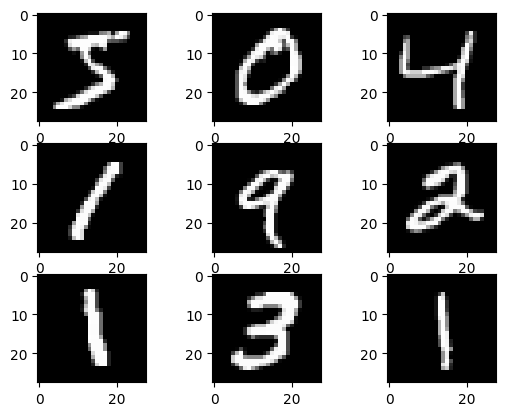

In [ ]:
(trainX, trainy), (testX, testy) = mnist.load_data()

print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))

# show the figure
pyplot.show()

Let's ensure that the data is evenly distributed per class (if not, we would have to make corrections). We should expect that each class represents roughly 10% of the entire dataset.


In [ ]:
for i in range(10):
  count_train = np.where(trainy == i)[0]
  count_test = np.where(testy == i)[0]

  print("Label %d - train: %.4f - test: %.4f" %(i, count_train.shape[0] / float(trainy.shape[0]), count_test.shape[0] / float(testy.shape[0]) ))

Label 0 - train: 0.0987 - test: 0.0980
Label 1 - train: 0.1124 - test: 0.1135
Label 2 - train: 0.0993 - test: 0.1032
Label 3 - train: 0.1022 - test: 0.1010
Label 4 - train: 0.0974 - test: 0.0982
Label 5 - train: 0.0903 - test: 0.0892
Label 6 - train: 0.0986 - test: 0.0958
Label 7 - train: 0.1044 - test: 0.1028
Label 8 - train: 0.0975 - test: 0.0974
Label 9 - train: 0.0992 - test: 0.1009


Ok, it looks good....we can work with these classes as is. Now let's start doing some prediction. We should split the training data into train and dev sets.


Now let's try building a 2-layer feed forward network to predict digits. Remember, each data point is a 28x28 image, so you will need to flatten it into a vector for a feed forward DNN.

In [ ]:
#Define DNN class here
class TwoLayerDNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TwoLayerDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
#Train DNN and predict on test

# Hyperparameters
input_size = 28*28  # Flattened image size
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
model = TwoLayerDNN(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Data loading and preprocessing
train_images = torch.from_numpy(trainX).reshape(-1, input_size).float()
train_labels = torch.from_numpy(trainy).long()
test_images = torch.from_numpy(testX).reshape(-1, input_size).float()
test_labels = torch.from_numpy(testy).long()

train_dataset = torch.utils.data.TensorDataset(train_images, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_images, test_labels)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
# In test phase, we don't need to compute gradients (for efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/5], Step [100/600], Loss: 1.2970
Epoch [1/5], Step [200/600], Loss: 0.1244
Epoch [1/5], Step [300/600], Loss: 0.2091
Epoch [1/5], Step [400/600], Loss: 0.4289
Epoch [1/5], Step [500/600], Loss: 0.1655
Epoch [1/5], Step [600/600], Loss: 0.1171
Epoch [2/5], Step [100/600], Loss: 0.0750
Epoch [2/5], Step [200/600], Loss: 0.1868
Epoch [2/5], Step [300/600], Loss: 0.2158
Epoch [2/5], Step [400/600], Loss: 0.0484
Epoch [2/5], Step [500/600], Loss: 0.0609
Epoch [2/5], Step [600/600], Loss: 0.2098
Epoch [3/5], Step [100/600], Loss: 0.0250
Epoch [3/5], Step [200/600], Loss: 0.0547
Epoch [3/5], Step [300/600], Loss: 0.0894
Epoch [3/5], Step [400/600], Loss: 0.0426
Epoch [3/5], Step [500/600], Loss: 0.0343
Epoch [3/5], Step [600/600], Loss: 0.2075
Epoch [4/5], Step [100/600], Loss: 0.0503
Epoch [4/5], Step [200/600], Loss: 0.1712
Epoch [4/5], Step [300/600], Loss: 0.1173
Epoch [4/5], Step [400/600], Loss: 0.0733
Epoch [4/5], Step [500/600], Loss: 0.1050
Epoch [4/5], Step [600/600], Loss:

Report:
- precision
- recall
- ROC curve
- confusion matrix

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.94      0.96      0.95      1032
           3       0.96      0.93      0.94      1010
           4       0.96      0.94      0.95       982
           5       0.97      0.93      0.95       892
           6       0.97      0.98      0.98       958
           7       0.94      0.96      0.95      1028
           8       0.96      0.96      0.96       974
           9       0.93      0.94      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000

Confusion Matrix:
[[ 970    0    0    2    1    1    4    1    0    1]
 [   1 1126    0    1    0    2    1    2    2    0]
 [  10    4  995    3    0    0    2   12    5    1]
 [   0    1   15  941    1   11    1   15

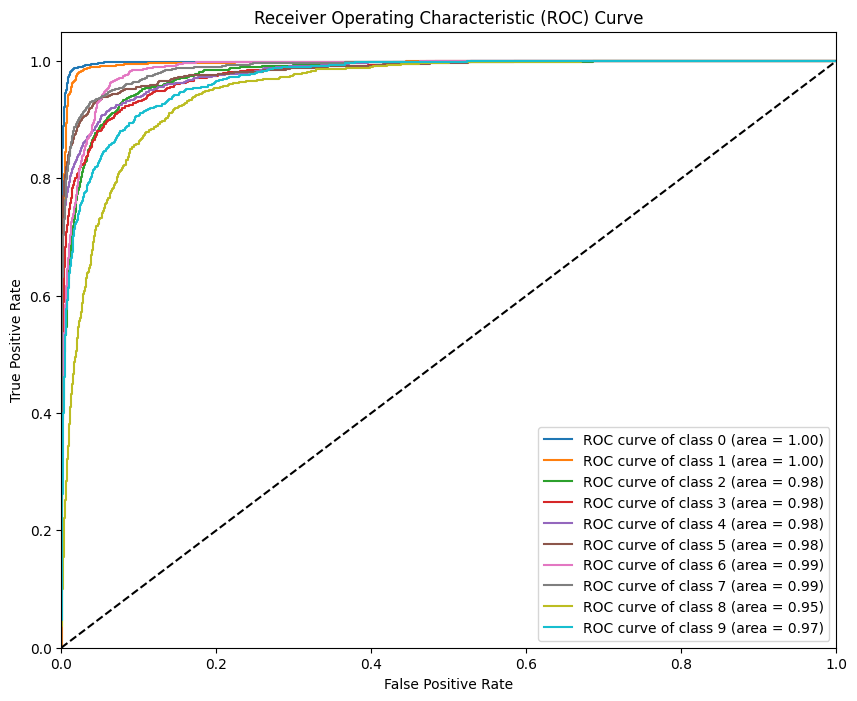

In [ ]:
#Enter code here
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# ROC Curve (for multi-class, typically done per class or micro/macro average)
# Let's calculate for each class

# Binarize the output
y_test_bin = label_binarize(true_labels, classes=range(num_classes))
# Ensure model is on the correct device and in evaluation mode
model.eval()
with torch.no_grad():
    y_score = model(test_images.to(device)).cpu().detach().numpy() # Get the raw scores from the model

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Now let's build a CNN network for image recognition.

In [ ]:
# Define CNN

class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [ ]:
# Train CNN and predict on test

# Hyperparameters
num_epochs_cnn = 5
batch_size_cnn = 100
learning_rate_cnn = 0.001

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
cnn_model = CNN(num_classes).to(device)

# Loss and optimizer
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=learning_rate_cnn)

# Data loading and preprocessing for CNN (add channel dimension)
train_images_cnn = torch.from_numpy(trainX).unsqueeze(1).float()
train_labels_cnn = torch.from_numpy(trainy).long()
test_images_cnn = torch.from_numpy(testX).unsqueeze(1).float()
test_labels_cnn = torch.from_numpy(testy).long()

train_dataset_cnn = torch.utils.data.TensorDataset(train_images_cnn, train_labels_cnn)
test_dataset_cnn = torch.utils.data.TensorDataset(test_images_cnn, test_labels_cnn)

train_loader_cnn = torch.utils.data.DataLoader(dataset=train_dataset_cnn, batch_size=batch_size_cnn, shuffle=True)
test_loader_cnn = torch.utils.data.DataLoader(dataset=test_dataset_cnn, batch_size=batch_size_cnn, shuffle=False)


# Train the model
total_step_cnn = len(train_loader_cnn)
for epoch in range(num_epochs_cnn):
    for i, (images, labels) in enumerate(train_loader_cnn):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = cnn_model(images)
        loss = criterion_cnn(outputs, labels)

        # Backward and optimize
        optimizer_cnn.zero_grad()
        loss.backward()
        optimizer_cnn.step()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs_cnn, i+1, total_step_cnn, loss.item()))

# Test the model
# In test phase, we don't need to compute gradients (for efficiency)
with torch.no_grad():
    correct_cnn = 0
    total_cnn = 0
    predicted_labels_cnn = []
    true_labels_cnn = []
    for images, labels in test_loader_cnn:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_cnn += labels.size(0)
        correct_cnn += (predicted == labels).sum().item()
        predicted_labels_cnn.extend(predicted.cpu().numpy())
        true_labels_cnn.extend(labels.cpu().numpy())


    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct_cnn / total_cnn))

Epoch [1/5], Step [100/600], Loss: 0.2206
Epoch [1/5], Step [200/600], Loss: 0.1316
Epoch [1/5], Step [300/600], Loss: 0.0859
Epoch [1/5], Step [400/600], Loss: 0.0423
Epoch [1/5], Step [500/600], Loss: 0.0875
Epoch [1/5], Step [600/600], Loss: 0.1469
Epoch [2/5], Step [100/600], Loss: 0.0512
Epoch [2/5], Step [200/600], Loss: 0.0159
Epoch [2/5], Step [300/600], Loss: 0.0156
Epoch [2/5], Step [400/600], Loss: 0.0527
Epoch [2/5], Step [500/600], Loss: 0.1740
Epoch [2/5], Step [600/600], Loss: 0.0870
Epoch [3/5], Step [100/600], Loss: 0.1129
Epoch [3/5], Step [200/600], Loss: 0.1325
Epoch [3/5], Step [300/600], Loss: 0.0564
Epoch [3/5], Step [400/600], Loss: 0.0513
Epoch [3/5], Step [500/600], Loss: 0.0597
Epoch [3/5], Step [600/600], Loss: 0.0409
Epoch [4/5], Step [100/600], Loss: 0.0119
Epoch [4/5], Step [200/600], Loss: 0.0206
Epoch [4/5], Step [300/600], Loss: 0.0401
Epoch [4/5], Step [400/600], Loss: 0.1732
Epoch [4/5], Step [500/600], Loss: 0.0027
Epoch [4/5], Step [600/600], Loss:

Report:
- precision
- recall
- ROC curve
- confusion matrix

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.97      0.98       892
           6       1.00      0.98      0.99       958
           7       0.97      0.99      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Confusion Matrix:
[[ 973    0    0    0    3    0    2    2    0    0]
 [   0 1131    0    0    0    2    1    1    0    0]
 [   1    3 1012    0    3    0    0   12    1    0]
 [   2    0    3  990    0    1    0    3

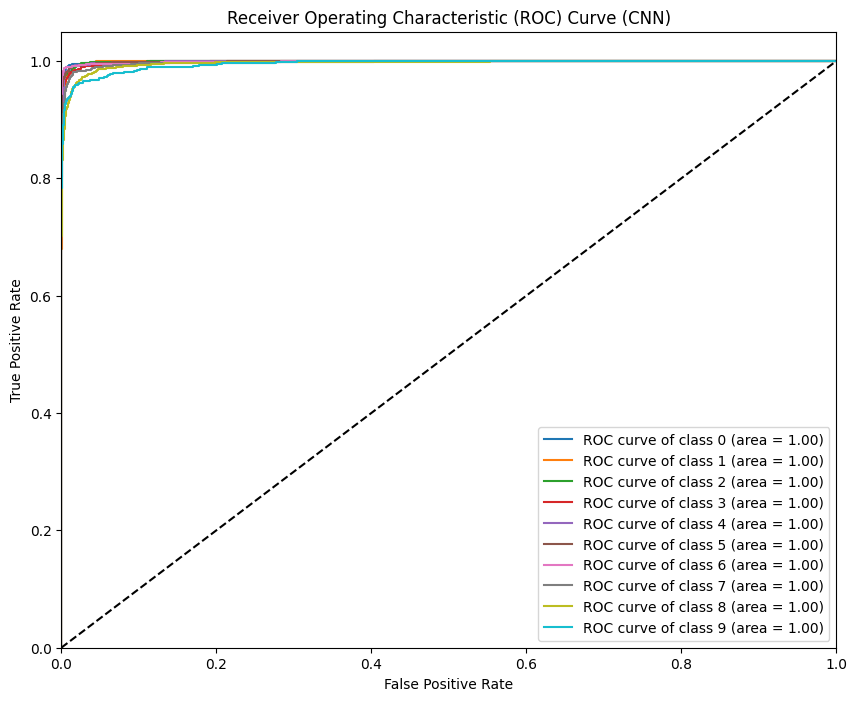

In [ ]:
#Enter code here
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Classification Report
print("Classification Report:")
print(classification_report(true_labels_cnn, predicted_labels_cnn))

# Confusion Matrix
conf_matrix_cnn = confusion_matrix(true_labels_cnn, predicted_labels_cnn)
print("Confusion Matrix:")
print(conf_matrix_cnn)

# ROC Curve (for multi-class, typically done per class or micro/macro average)
# Let's calculate for each class

# Binarize the output
y_test_bin_cnn = label_binarize(true_labels_cnn, classes=range(num_classes))
cnn_model.eval() # Set model to evaluation mode
with torch.no_grad():
  y_score_cnn = cnn_model(test_images_cnn.to(device)).cpu().detach().numpy() # Get the raw scores from the model

fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
for i in range(num_classes):
    fpr_cnn[i], tpr_cnn[i], _ = roc_curve(y_test_bin_cnn[:, i], y_score_cnn[:, i])
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr_cnn[i], tpr_cnn[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_cnn[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (CNN)')
plt.legend(loc="lower right")
plt.show()

At this point, you should have seen an improvement in performance when using CNN for images over DNN. Look into the performance metrics (specially the confusion matrix), and try to identify where CNNs made a difference in performance.

Are there specific number pairs that were difficult for DNN but improved on CNN?

Finally, pick a pair of classes that have high confusion an plot examples that are confusing between them. Can you see why the confusion happens? (This type of post-hoc investigation is typical in the industry to understand why/when something might fail, and work towards fixing those edge cases).



In [ ]:
#Enter code here